In [3]:
import json
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.calibration import CalibrationDisplay

In [12]:
def ece(data, labels, n_bins=10):
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data[..., np.newaxis]).reshape(-1,)
    bins = np.linspace(0, 1, n_bins+1).tolist()
    bin_idxs = [x+1 for x in range(n_bins)]
    binned_data = np.digitize(data_scaled, bins)
    ece = 0
    for bin_id in bin_idxs:
        bin_items = binned_data==bin_id
        if sum(bin_items)==0:
            continue
        conf = np.mean(data_scaled[bin_items])
        acc = np.mean(labels[bin_items])
        ece += abs(acc-conf)*sum(bin_items)
    ece = ece/len(data)
    return ece
    

In [26]:
true_dataset = 'paws'
files = [x for x in os.listdir('../true/results/') if '.json' in x]
data = {}
for idx, file in enumerate(files):
    with open('../true/results/'+file, 'r') as f:
        d = json.load(f)
    if type(d[true_dataset]) == dict:
        data[file.split('_results')[0]] = d[true_dataset]['unstructured_score']
        if idx==0:
            data[file.split('_results')[0]] = d[true_dataset]['incorrect']
    else:
        data[file.split('_results')[0]] = d[true_dataset][0]
        if idx==0:
            data['label'] = d[true_dataset][1]

In [27]:
datal = {k:data[k] for k in data.keys() if len(data[k])==len(data['label'])}
datal.keys()

dict_keys(['summac_zs_true', 'label', 'scale_large_true', 'unieval_true', 'summac_conv_true', 'bert_score_f_true'])

In [28]:
df = pd.DataFrame(datal)
df.columns

Index(['summac_zs_true', 'label', 'scale_large_true', 'unieval_true',
       'summac_conv_true', 'bert_score_f_true'],
      dtype='object')

In [31]:
#run for making figure 3
df = df[['scale_large_true', 'summac_zs_true', 'summac_conv_true', 'unieval_true',  'bert_score_f_true', 'label']]

scale_large_true
0.01985211442165353
summac_zs_true
0.24419575163426085
summac_conv_true
0.08467522643188916
unieval_true
0.5071609414204407
bert_score_f_true
0.31195207253081003


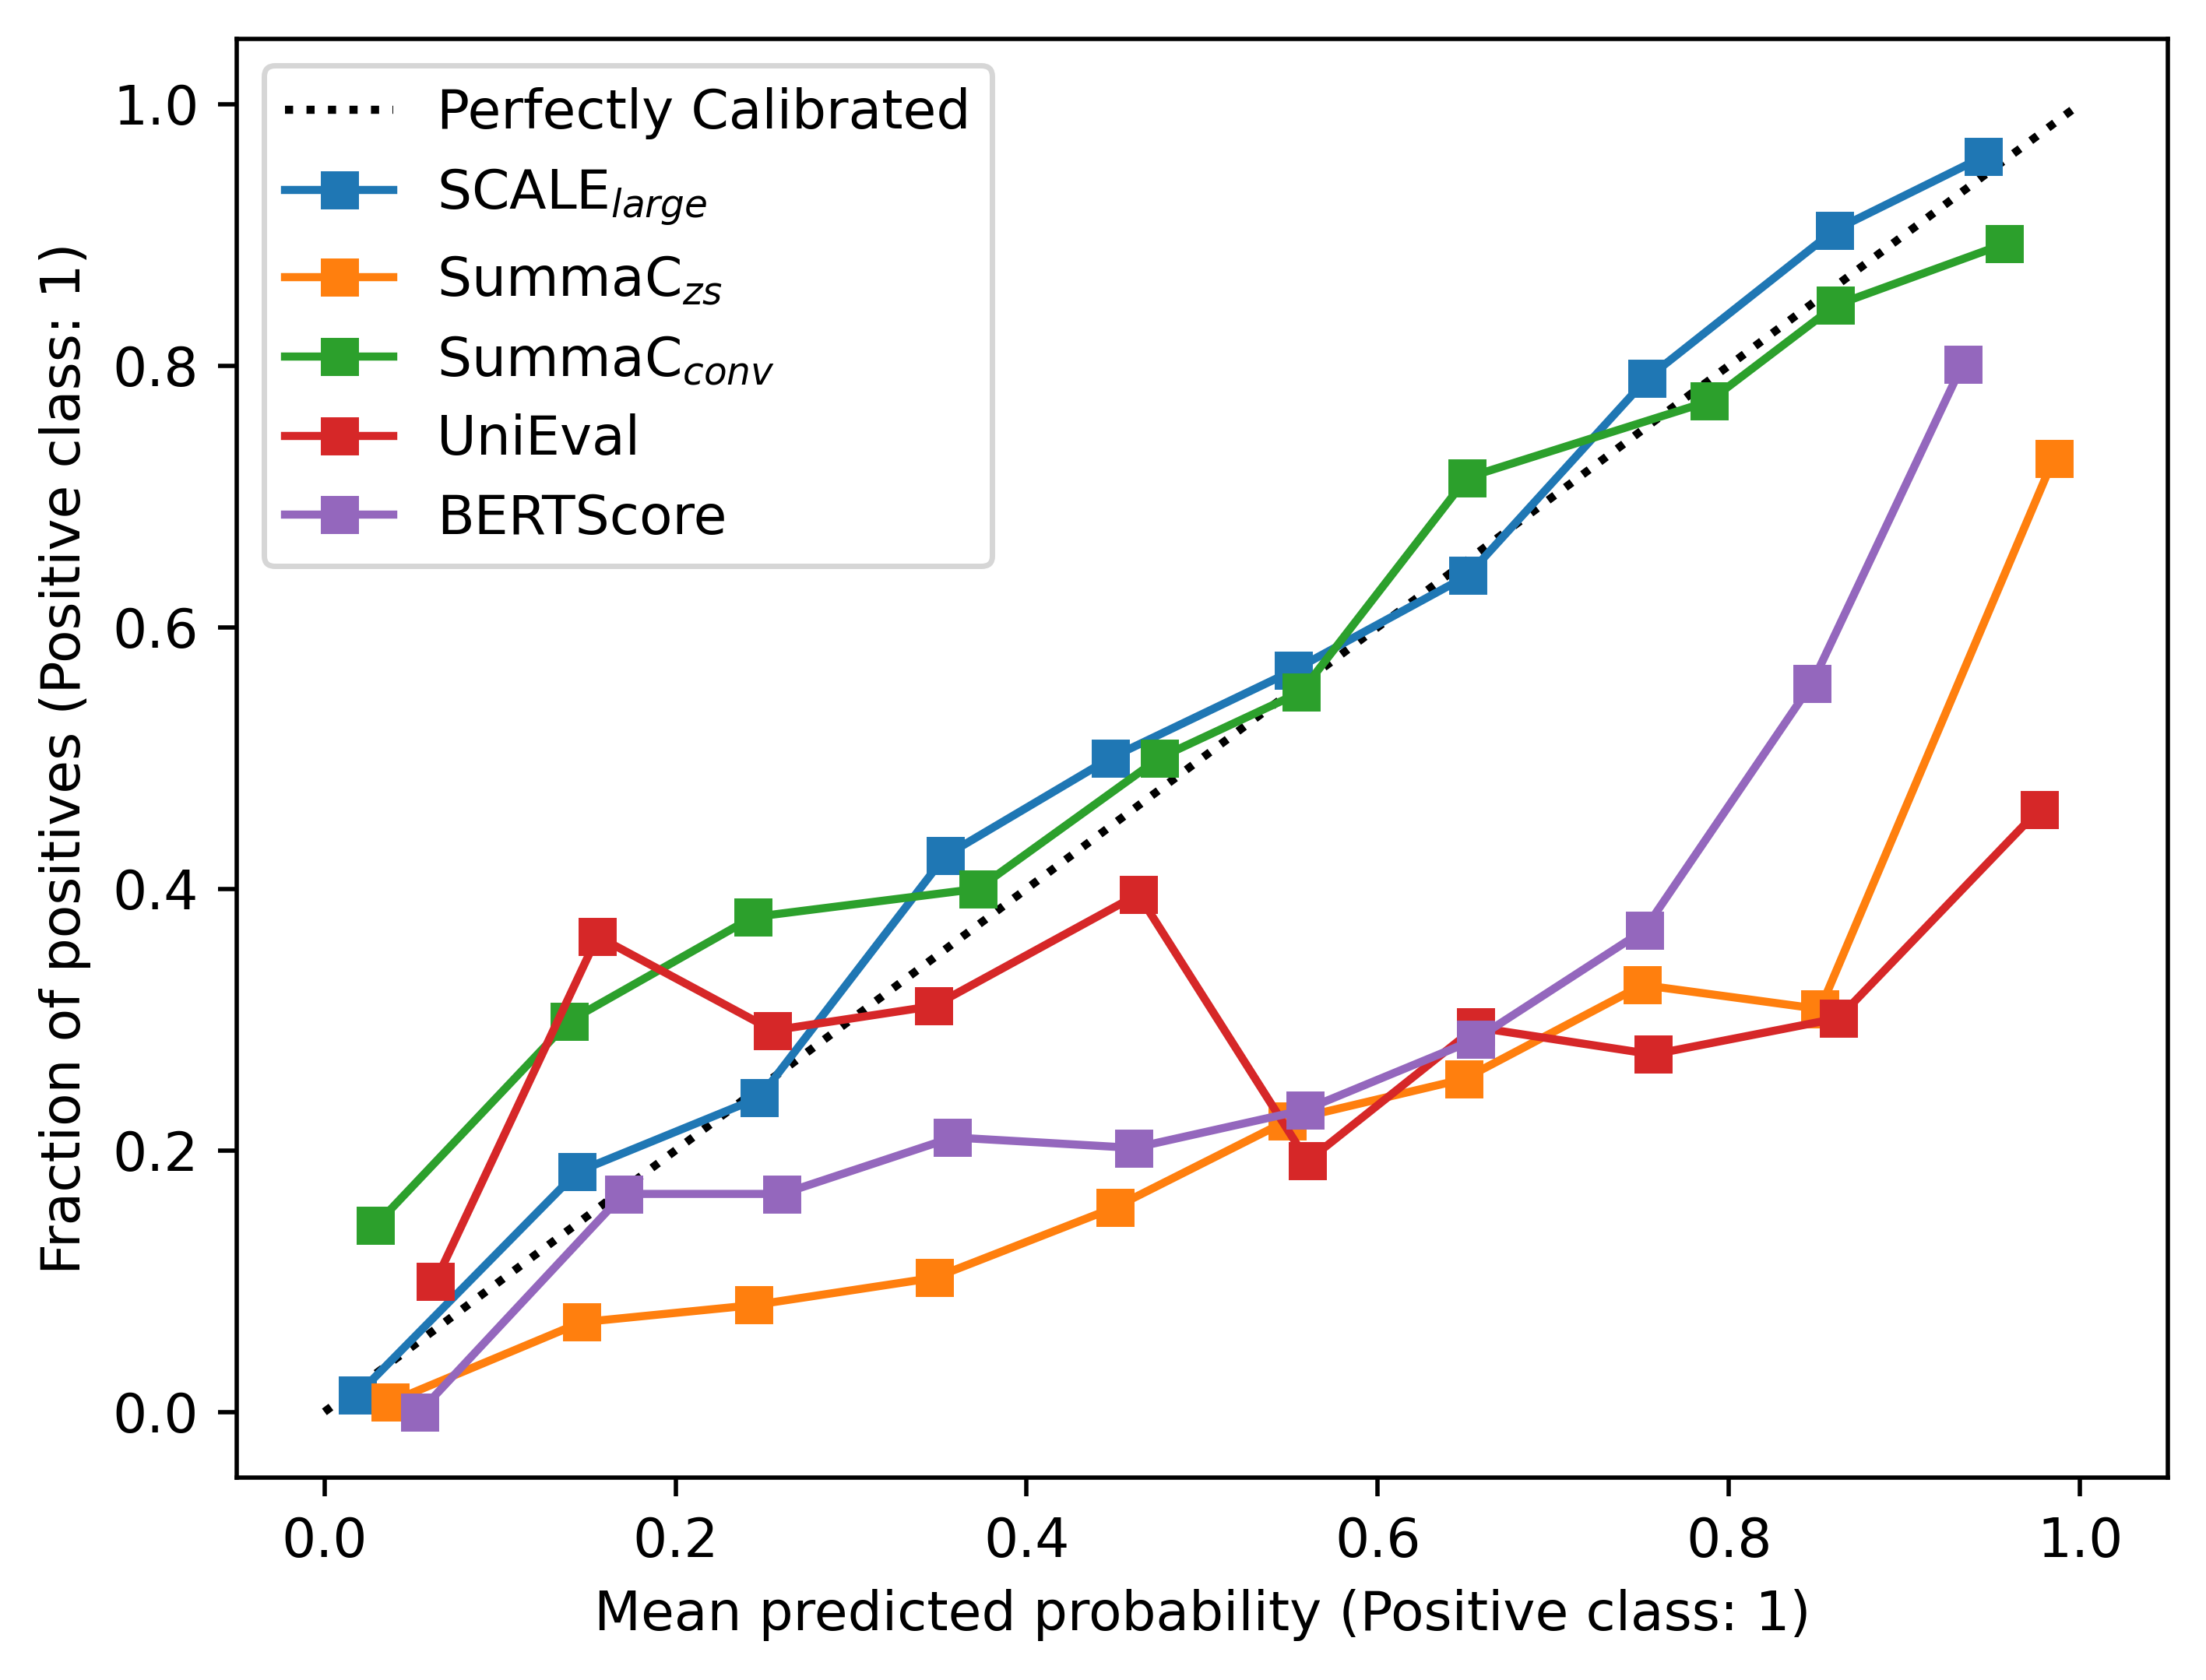

In [36]:
scaler = MinMaxScaler()
data = {}
for idx, x in enumerate([x for x in df.columns]):
    if x=='label':
        continue
    print(x)
    print(ece(df[x].to_numpy(), df['label'].to_numpy(), 15))
    data[x.split('_')[-1]] = ece(df[x].to_numpy(), df['label'].to_numpy(), 15)
    if idx==0:
        disp = CalibrationDisplay.from_predictions(df['label'], [y if y<=1 and y>=0 else round(y, 2) for y in scaler.fit_transform(df[x].to_numpy()[..., np.newaxis]).reshape(-1,).tolist()], n_bins=10, name=x)
    else:
        disp = CalibrationDisplay.from_predictions(df['label'], [y if y<=1 and y>=0 else round(y, 2) for y in scaler.fit_transform(df[x].to_numpy()[..., np.newaxis]).reshape(-1,).tolist()], n_bins=10, name=x,  ax=disp.ax_)

plt.rcParams['figure.dpi'] = 500
labels = ['Perfectly Calibrated', r'$\mathrm{SCALE}_{large}$', r'$\mathrm{SummaC}_{zs}$', 
          r'$\mathrm{SummaC}_{conv}$' , r'UniEval', r'BERTScore']

plt.legend(labels)
plt.show()

# Calibration vs Chunk Size

In [5]:
files = [x for x in os.listdir('../chunk_size/results/') if '.json' in x and 'large' in x]
data = {}
for idx, file in enumerate(files):
    with open('../chunk_size/results/'+file, 'r') as f:
        d = json.load(f)
    data[file.split('_results')[0]] = d[0]
    if idx==0:
        data['label'] = d[1]
df = pd.DataFrame(data)
df.columns

Index(['flan_t5_large_3000', 'label', 'flan_t5_large_2000',
       'flan_t5_large_750', 'flan_t5_large_100', 'flan_t5_large_500',
       'flan_t5_large_300', 'flan_t5_large_1000'],
      dtype='object')

flan_t5_large_3000
0.3142205084027999
flan_t5_large_2000
0.29643459288490326
flan_t5_large_750
0.27373716673515897
flan_t5_large_100
0.33333040280161946
flan_t5_large_500
0.27283337569138305
flan_t5_large_300
0.28612613880494775
flan_t5_large_1000
0.28000325570471085


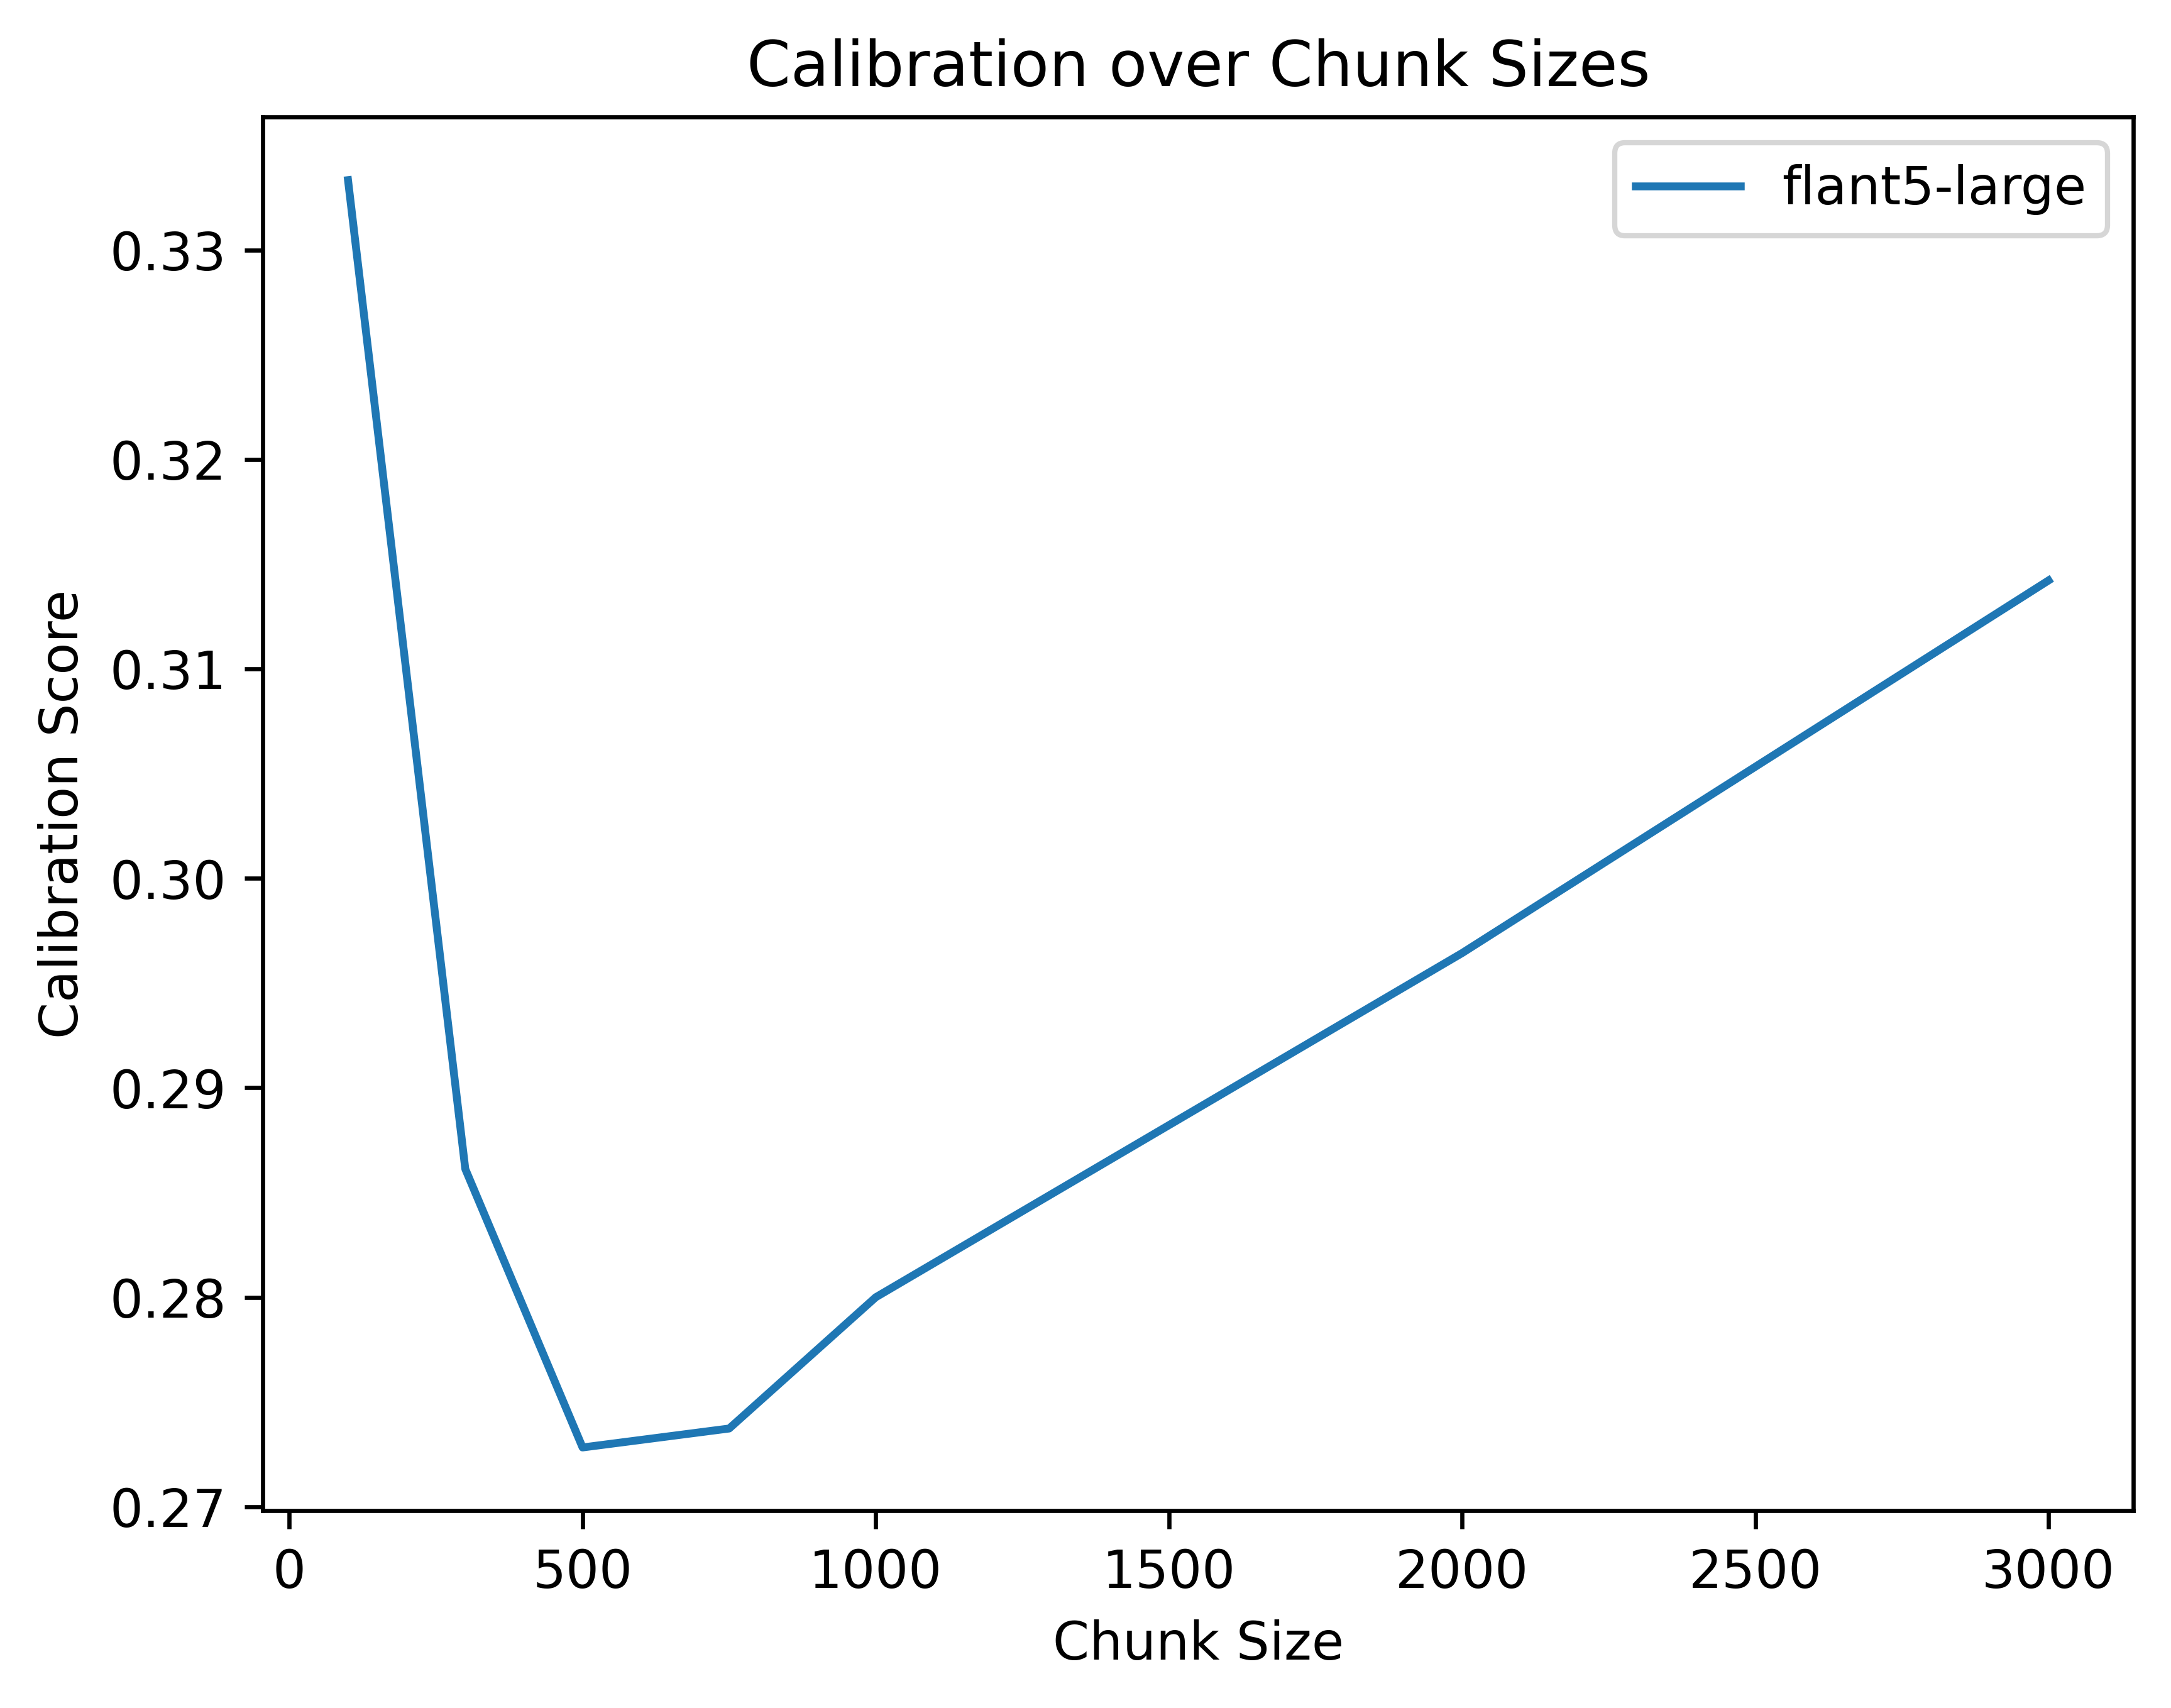

In [9]:
scaler = MinMaxScaler()
data = {}
for idx, x in enumerate([x for x in df.columns]):
    if x=='label':
        continue
    print(x)
    print(ece(df[x].to_numpy(), df['label'].to_numpy(), 15))
    data[x.split('_')[-1]] = ece(df[x].to_numpy(), df['label'].to_numpy(), 15)

d = {int(k):v for k,v in data.items()}
ddf = pd.DataFrame(d, index=[0])
ddf = ddf.reindex(sorted(ddf.columns), axis=1)

ax = ddf.T.plot(kind='line')
ax.set_title('Calibration over Chunk Sizes')
ax.set_ylabel('Calibration Score')
ax.set_xlabel('Chunk Size')
ax.legend(['flant5-large'])
plt.rcParams['figure.dpi'] = 500
plt.show()
